In [55]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import statistics as stat
plt.style.use('ggplot')

np.random.seed(1) #ensure reproducibility

# Set some Pandas options
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

In [56]:
patients = pd.read_csv("data/gbm_data.csv")
patients.head()

,Sex,Age,Alive,Biopsy,IcRET,CRET,Tside,IDHStatus,MGMT,SxDeficit,SxHeadache,SxSeizure,ZeroGy,ThirtyGy,FortyGy,SixtyGy,TMZ
0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1
1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1
2,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1
3,1,1,1,0,0,1,1,0,1,0,0,1,0,0,0,1,1
4,0,1,0,0,0,1,1,1,1,0,0,1,0,0,0,1,1


<AxesSubplot:xlabel='Alive'>

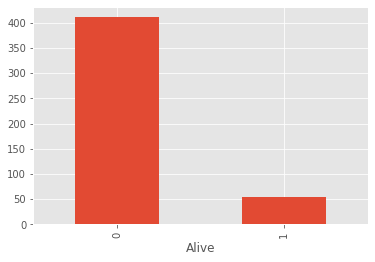

In [57]:
#shows that the groups are not evenly spread - many more Alive people than alive after 18months
patients.pivot_table(index='Alive', aggfunc='size').plot(kind='bar')

In [58]:
# Create a stratified train/test split. 
# Test set will be 30% of the data.
# Class distribution will be equal for train test and original data

from sklearn.model_selection import train_test_split
train, test = train_test_split(patients, test_size = 0.3, stratify=patients.Alive)

<AxesSubplot:title={'center':'Class distributuion in train data'}, xlabel='Alive'>

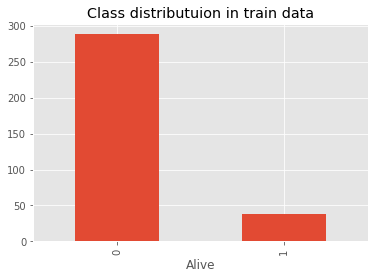

In [59]:
train.pivot_table(index='Alive', aggfunc='size').plot(kind='bar', title='Class distributuion in train data')

<AxesSubplot:title={'center':'Class distributuion in test data'}, xlabel='Alive'>

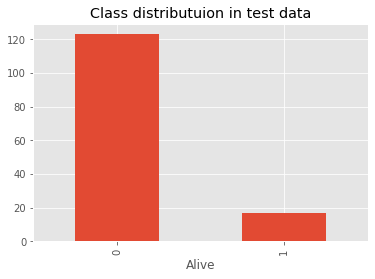

In [60]:
test.pivot_table(index='Alive', aggfunc='size').plot(kind='bar', title='Class distributuion in test data')

In [61]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression with only default settings
lr = LogisticRegression()
lr_columns = ['Sex','Age','Biopsy','IcRET','CRET','Tside','IDHStatus','MGMT','SxDeficit','SxHeadache','SxSeizure','ZeroGy','ThirtyGy','FortyGy','SixtyGy','TMZ']
# Fit the logistic regression on the independent variables of the train data with Alive as dependent variable
lr.fit(train[lr_columns], train['Alive'])

# Make a prediction using our model on the test set
preds = lr.predict(test[lr_columns])


In [62]:

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test['Alive'], preds).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  119 
False positives:  4 
False negatives:  15 
True Positives:  2


In [63]:
# Precision means how well a model succeeds in identifying ONLY positive cases. 
# Recall means how well a model succeeds in identifying ALL the positive cases within the data.
from sklearn.metrics import classification_report
print(classification_report(test['Alive'], preds))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       123
           1       0.33      0.12      0.17        17

    accuracy                           0.86       140
   macro avg       0.61      0.54      0.55       140
weighted avg       0.82      0.86      0.83       140



<AxesSubplot:title={'center':'Class distribution after applying SMOTE'}, xlabel='Alive'>

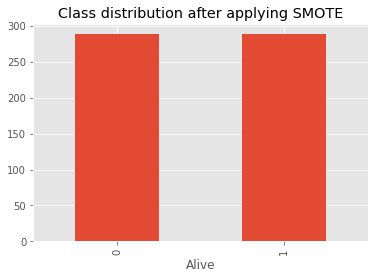

In [64]:
# start to use SMOTE function
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(train[['Sex','Age','Biopsy','IcRET','CRET','Tside','IDHStatus','MGMT','SxDeficit','SxHeadache','SxSeizure','ZeroGy','ThirtyGy','FortyGy','SixtyGy','TMZ']], train['Alive'])
pd.Series(y_resampled).value_counts().plot(kind='bar', title='Class distribution after applying SMOTE', xlabel='Alive')


<AxesSubplot:title={'center':'Class distribution after applying SMOTE with Test data'}, xlabel='Alive'>

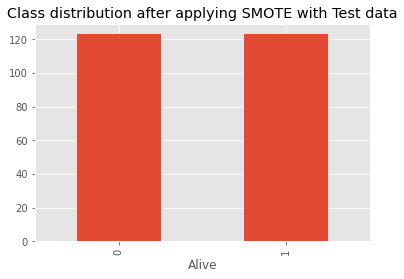

In [65]:
X_resampled2, y_resampled2 = SMOTE().fit_resample(test[['Sex','Age','Biopsy','IcRET','CRET','Tside','IDHStatus','MGMT','SxDeficit','SxHeadache','SxSeizure','ZeroGy','ThirtyGy','FortyGy','SixtyGy','TMZ']], test['Alive'])
pd.Series(y_resampled2).value_counts().plot(kind='bar', title='Class distribution after applying SMOTE with Test data', xlabel='Alive')


In [66]:
# Instantiate the new Logistic Regression
lr_smote = LogisticRegression()

# Fit the model with the data that has been resampled with SMOTE
lr_smote.fit(X_resampled, y_resampled)

# Predict on the test set (not resampled to obtain honest evaluation)
pred_smote = lr_smote.predict(X_resampled2)

In [72]:
tn, fp, fn, tp = confusion_matrix(y_resampled2, pred_smote).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

True negatives:  96 
False positives:  27 
False negatives:  23 
True positives:  100


In [68]:
#Precision means how well a model succeeds in identifying ONLY positive cases. 
#Recall means how well a model succeeds in identifying ALL the positive cases within the data.

print(classification_report(y_resampled2, pred_smote))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       123
           1       0.79      0.81      0.80       123

    accuracy                           0.80       246
   macro avg       0.80      0.80      0.80       246
weighted avg       0.80      0.80      0.80       246



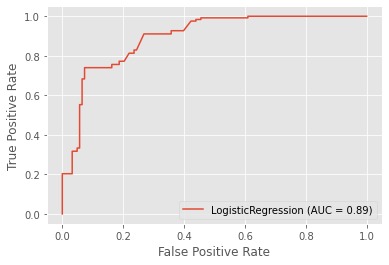

In [69]:
from sklearn.metrics import RocCurveDisplay

lr_roc_smote = RocCurveDisplay.from_estimator(lr_smote, X_resampled2, y_resampled2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

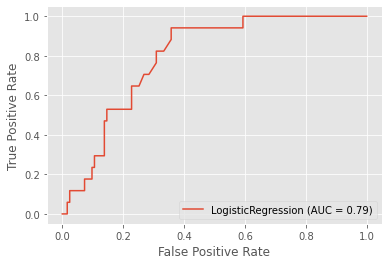

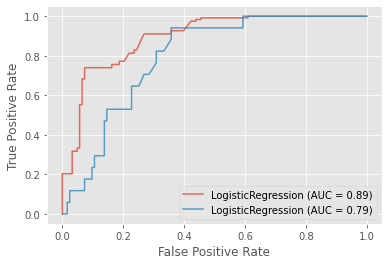

In [70]:
lr_roc = RocCurveDisplay.from_estimator(lr, test[['Sex','Age','Biopsy','IcRET','CRET','Tside','IDHStatus','MGMT','SxDeficit','SxHeadache','SxSeizure','ZeroGy','ThirtyGy','FortyGy','SixtyGy','TMZ']], test['Alive'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ax = plt.gca()
lr_roc_smote.plot(ax=ax, alpha=0.8)
lr_roc.plot(ax=ax, alpha=0.8)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('figures/LR ROC curves.png', dpi=300, bbox_inches='tight')
plt.show()

Logistic: f1=0.800 auc=0.877


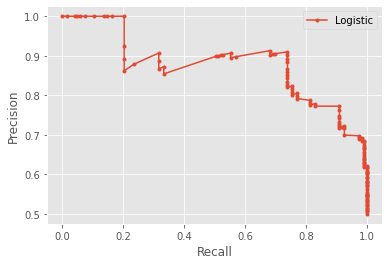

In [71]:
# precision-recall curve and f1 for an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve, f1_score, auc

# predict probabilities
lr_probs = lr_smote.predict_proba(X_resampled2)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = lr_smote.predict(X_resampled2)
# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_resampled2, lr_probs)
# calculate scores
lr_f1, lr_auc = f1_score(y_resampled2, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Importance base data
Feature: 0, Score: -0.17963
Feature: 1, Score: 0.87614
Feature: 2, Score: -0.54951
Feature: 3, Score: -0.33912
Feature: 4, Score: 0.88850
Feature: 5, Score: -0.09994
Feature: 6, Score: 1.22236
Feature: 7, Score: 1.09569
Feature: 8, Score: -0.08180
Feature: 9, Score: 0.14487
Feature: 10, Score: -0.06321
Feature: 11, Score: -0.83226
Feature: 12, Score: 0.05480
Feature: 13, Score: -0.46539
Feature: 14, Score: 1.24272
Feature: 15, Score: 0.57396


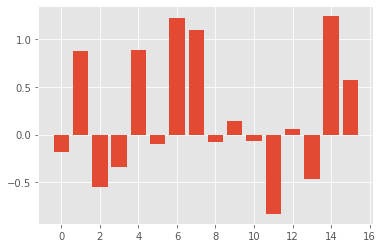

In [25]:
# get importance
importance = lr.coef_[0]
print('Importance base data')
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
#The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0

Importance SMOTE data
Feature: 0, Score: -0.55905
Feature: 1, Score: 0.84325
Feature: 2, Score: -2.85895
Feature: 3, Score: -2.51820
Feature: 4, Score: -0.71066
Feature: 5, Score: -0.89950
Feature: 6, Score: 0.76611
Feature: 7, Score: 1.06879
Feature: 8, Score: -1.62960
Feature: 9, Score: -1.52628
Feature: 10, Score: -1.50040
Feature: 11, Score: -2.09140
Feature: 12, Score: -0.98350
Feature: 13, Score: -1.43278
Feature: 14, Score: 1.06849
Feature: 15, Score: 0.16568


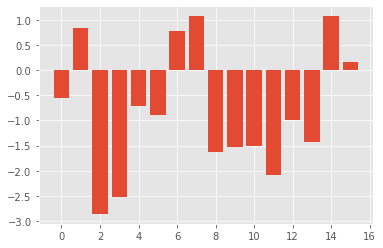

In [26]:
# get importance
importance = lr_smote.coef_[0]
print('Importance SMOTE data')
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
#The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0

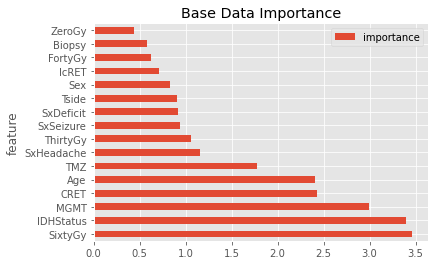

In [27]:
feature_names = ['Sex','Age','Biopsy','IcRET','CRET','Tside','IDHStatus','MGMT','SxDeficit','SxHeadache','SxSeizure','ZeroGy','ThirtyGy','FortyGy','SixtyGy','TMZ']
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, lr.coef_[0])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 
ax = feature_importance.plot.barh(x='feature', y='importance', title='Base Data Importance')
plt.savefig('figures/lr_importance.png', dpi=300, bbox_inches='tight')
plt.show()

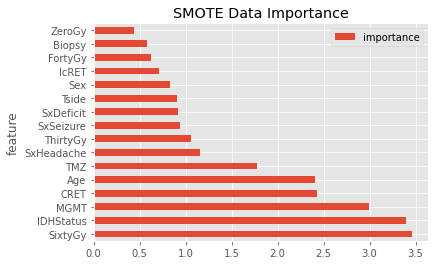

In [28]:
feature_names = ['Sex','Age','Biopsy','IcRET','CRET','Tside','IDHStatus','MGMT','SxDeficit','SxHeadache','SxSeizure','ZeroGy','ThirtyGy','FortyGy','SixtyGy','TMZ']
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, lr.coef_[0])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 
ax = feature_importance.plot.barh(x='feature', y='importance', title='SMOTE Data Importance')
plt.savefig('figures/lr_smote_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 100000 decision trees
rf = RandomForestClassifier(n_estimators = 100000, random_state = 42)
# Train the model on training data
rf.fit(train[['Sex','Age','Biopsy','IcRET','CRET','Tside','IDHStatus','MGMT','SxDeficit','SxHeadache','SxSeizure','ZeroGy','ThirtyGy','FortyGy','SixtyGy','TMZ']], train['Alive'])


RandomForestClassifier(n_estimators=100000, random_state=42)

In [28]:
#We will evaluate the model using repeated stratified k-fold cross-validation, with three repeats and 10 folds.
#We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(rf, test[['Sex','Age','Biopsy','IcRET','CRET','Tside','IDHStatus','MGMT','SxDeficit','SxHeadache','SxSeizure','ZeroGy','ThirtyGy','FortyGy','SixtyGy','TMZ']], test['Alive'], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Accuracy: 0.819 (0.066)


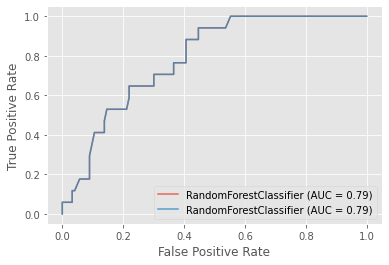

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, test[['Sex','Age','Biopsy','IcRET','CRET','Tside','IDHStatus','MGMT','SxDeficit','SxHeadache','SxSeizure','ZeroGy','ThirtyGy','FortyGy','SixtyGy','TMZ']], test['Alive'], ax=ax, alpha=0.8,)
rfc_disp.plot(ax=ax, alpha=0.8)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('figures/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [74]:

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 100000 decision trees
rfSMOTE = RandomForestClassifier(n_estimators = 100000, random_state = 42)
# Train the model on training data
rfSMOTE.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=100000, random_state=42)

In [75]:
#We will evaluate the model using repeated stratified k-fold cross-validation, with three repeats and 10 folds.
#We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(rfSMOTE, X_resampled2, y_resampled2, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.915 (0.055)


In [32]:
# install graphviz and pydotplus with command - pip install xx
import graphviz
import pydotplus
from IPython.display import Image  
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# Pull out one tree from the forest
branch = rfSMOTE.estimators_[5]
# Create DOT data
export_graphviz(branch,
                     out_file="figures/rf_map.dot",
                     feature_names = ['Sex','Age','Biopsy','IcRET','CRET','Tside','IDHStatus','MGMT','SxDeficit','SxHeadache','SxSeizure','ZeroGy','ThirtyGy','FortyGy','SixtyGy','TMZ'], 
                     class_names= 'Alive',
                     filled = True)
#then used an online dot converter tool    
# https://onlineconvertfree.com/convert/dot/           

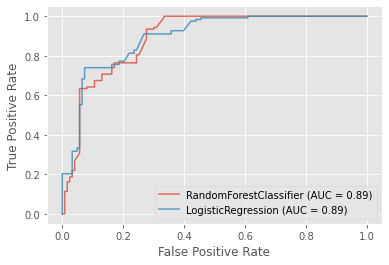

In [76]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfSMOTE, X_resampled2, y_resampled2, ax=ax, alpha=0.8,)
lr_roc_smote.plot(ax=ax, alpha=0.8)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('figures/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
#I added the label to the RF ROC curve and lost the automatic AUC so added it in manually

RF Smote Importance
Feature: 0, Score: 0.06596
Feature: 1, Score: 0.06535
Feature: 2, Score: 0.10573
Feature: 3, Score: 0.06817
Feature: 4, Score: 0.07687
Feature: 5, Score: 0.06751
Feature: 6, Score: 0.01506
Feature: 7, Score: 0.08528
Feature: 8, Score: 0.05037
Feature: 9, Score: 0.02534
Feature: 10, Score: 0.02864
Feature: 11, Score: 0.04677
Feature: 12, Score: 0.03838
Feature: 13, Score: 0.00985
Feature: 14, Score: 0.15823
Feature: 15, Score: 0.09249


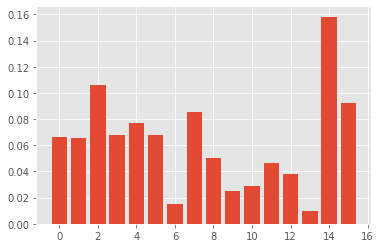

In [34]:
# get importance
importance = rfSMOTE.feature_importances_
print('RF Smote Importance')
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

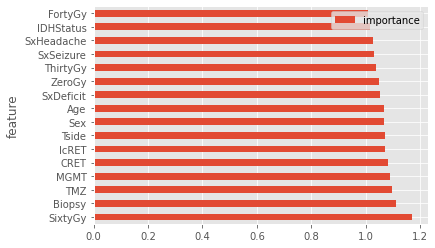

In [35]:
from sklearn.inspection import permutation_importance
feature_names = ['Sex','Age','Biopsy','IcRET','CRET','Tside','IDHStatus','MGMT','SxDeficit','SxHeadache','SxSeizure','ZeroGy','ThirtyGy','FortyGy','SixtyGy','TMZ']
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, rfSMOTE.feature_importances_)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.savefig('figures/rf_smote_importance.png', dpi=300, bbox_inches='tight')
plt.show()

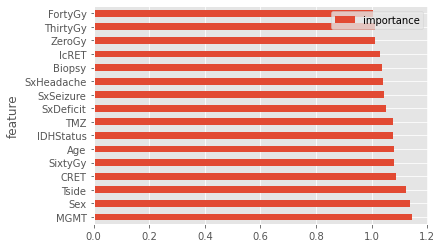

In [36]:
from sklearn.inspection import permutation_importance
feature_names = ['Sex','Age','Biopsy','IcRET','CRET','Tside','IDHStatus','MGMT','SxDeficit','SxHeadache','SxSeizure','ZeroGy','ThirtyGy','FortyGy','SixtyGy','TMZ']
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, rf.feature_importances_)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.savefig('figures/rf_importance.png', dpi=300, bbox_inches='tight')
plt.show()

RandomForest: f1=0.778 auc=0.830


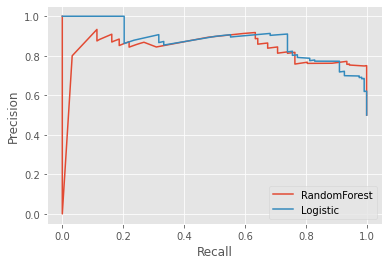

In [77]:
# predict probabilities
rf_probs = rfSMOTE.predict_proba(X_resampled2)
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
# predict class values
yhat = rfSMOTE.predict(X_resampled2)
# calculate precision and recall for each threshold
rf_precision, rf_recall, _ = precision_recall_curve(y_resampled2, rf_probs)
# calculate scores
rf_f1, rf_auc = f1_score(y_resampled2, yhat), auc(rf_recall, rf_precision)
# summarize scores
print('RandomForest: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
# plot the precision-recall curves
plt.plot(rf_recall, rf_precision, label='RandomForest')
plt.plot(lr_recall, lr_precision, label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.savefig('figures/precision_recall_curves.png', dpi=300, bbox_inches='tight')
# show the plot
plt.show()

In [78]:
# Use the forest's predict method on the test data
predictions = rfSMOTE.predict(train[lr_columns])
print('Predicted Class: %d' % predictions[0])

Predicted Class: 0


In [112]:
tmp = [
  1,
  80,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1
]
tmp_df = pd.DataFrame([tmp], columns=lr_columns)
tmp_df = patients[lr_columns]
tmp_df.head()

,Sex,Age,Biopsy,IcRET,CRET,Tside,IDHStatus,MGMT,SxDeficit,SxHeadache,SxSeizure,ZeroGy,ThirtyGy,FortyGy,SixtyGy,TMZ
0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,1
1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1
2,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1
3,1,1,0,0,1,1,0,1,0,0,1,0,0,0,1,1
4,0,1,0,0,1,1,1,1,0,0,1,0,0,0,1,1


In [113]:
print('LR prediction:', lr_smote.predict(tmp_df))
print('RF prediction:', rfSMOTE.predict(tmp_df))

LR prediction: [0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1
 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0
 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0
 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
RF prediction: [0 1 1 1 0 1 1 0 1 0 0 1

In [43]:
import joblib
joblib.dump(lr, 'model.pkl')
joblib.dump(lr_columns, 'model_columns.pkl')
print(lr_columns)

['Sex', 'Age', 'Biopsy', 'IcRET', 'CRET', 'Tside', 'IDHStatus', 'MGMT', 'SxDeficit', 'SxHeadache', 'SxSeizure', 'ZeroGy', 'ThirtyGy', 'FortyGy', 'SixtyGy', 'TMZ']
